# A/B test on payment model
____

Web agency developed a new payment model for its services. A/B test was completed: test group used a new payment model while control group used old one. 

**Problem**: if a new payment model will increase revenue.

In [63]:
# from google.colab import drive
# drive.mount('/content/drive')

In [64]:
# cd '/content/drive/My Drive/Colab Notebooks/'

In [65]:
# ls

In [31]:
# pip install bootstrapped

In [32]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, mannwhitneyu
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
import seaborn as sns
from matplotlib import pyplot as plt

**Data**:
- groups.csv: in which group each user is (А – control, B – test)
- active_studs.csv : active users during experiment
- checks.csv : information about sales during experiment



**Load and prepare data**

In [41]:
active_studs = pd.read_csv("active_studs.csv")
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [42]:
checks = pd.read_csv("checks.csv", sep=";")
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [43]:
groups = pd.read_csv("groups.csv", sep=";")
groups.head()

,id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


In [44]:
display(groups.shape[0], checks.shape[0], active_studs.shape[0])

74576

541

8341

In [45]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [46]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [47]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [48]:
groups.rename(columns={"id": "student_id"}, inplace=True)

In [49]:
groups.shape[0]

74576

In [50]:
checks.shape[0]

541

In [51]:
active_studs.shape[0]

8341

Merging datasets shows common student_id in merged datasets.

In [52]:
groups.merge(active_studs)

,student_id,grp
0,946259,B
1,1896859,B
2,938570,A
3,4808409,B
4,3242161,B
...,...,...
8336,1524221,B
8337,1302888,A
8338,1778339,B
8339,1138474,A


In [53]:
active_studs.merge(checks)

,student_id,rev
0,1184303,1530.0000
1,3354191,1900.0001
2,3278734,1900.0000
3,720651,1980.0000
4,1232221,1900.0000
...,...,...
387,3890326,199.0000
388,1390994,398.0000
389,1516339,290.0000
390,3910596,597.0000


Some rows are gone. Perhaps users neither from group A nor from group B paid for something.

In [54]:
real_students = active_studs.merge(checks)
real_students = real_students.merge(groups)
real_students.head()

,student_id,rev,grp
0,1184303,1530.0000,A
1,3354191,1900.0001,B
2,3278734,1900.0000,B
3,720651,1980.0000,A
4,1232221,1900.0000,B


Lets see distributions.

In [58]:
real_students.query("grp == 'A'").shape[0]

78

In [59]:
real_students.query("grp == 'B'").shape[0]

314

In [60]:
(78 / 314) * 100

24.840764331210192

A:B ratio is 25:75.

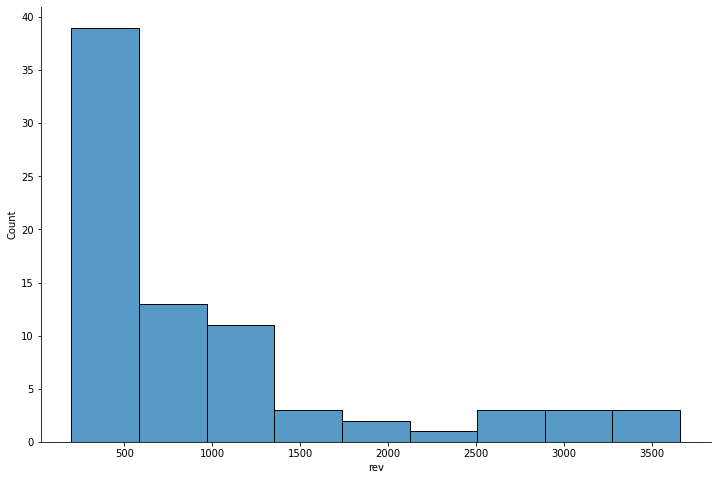

In [61]:
plt.figure(figsize=(12, 8))
sns.histplot(real_students.query(
    "grp == 'A'").rev)
sns.despine()

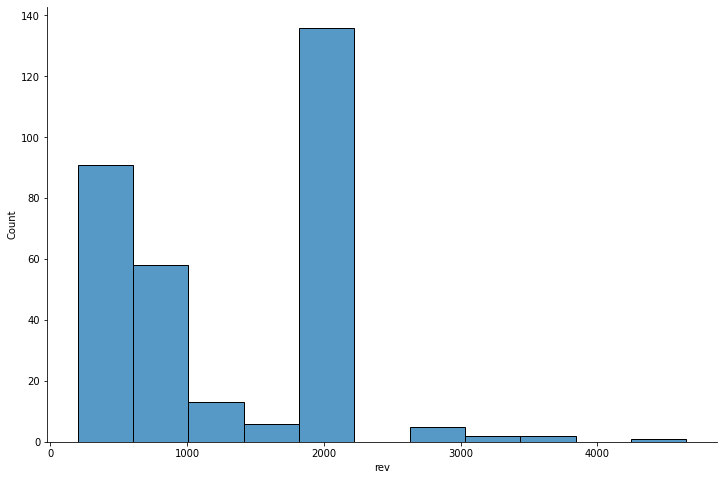

In [62]:
plt.figure(figsize=(12, 8))
sns.histplot(real_students.query("grp == 'B'").rev)
sns.despine()

In [66]:
print(shapiro(real_students.query("grp == 'A'").rev), shapiro(real_students.query("grp == 'B'").rev), sep="\n")

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)


Can see that distributions are not normal.
Lets try log transformation.

In [68]:
real_students["log_rev"] = np.log(real_students.rev)

In [69]:
a_group = real_students.query("grp == 'A'")
b_group = real_students.query("grp == 'B'")

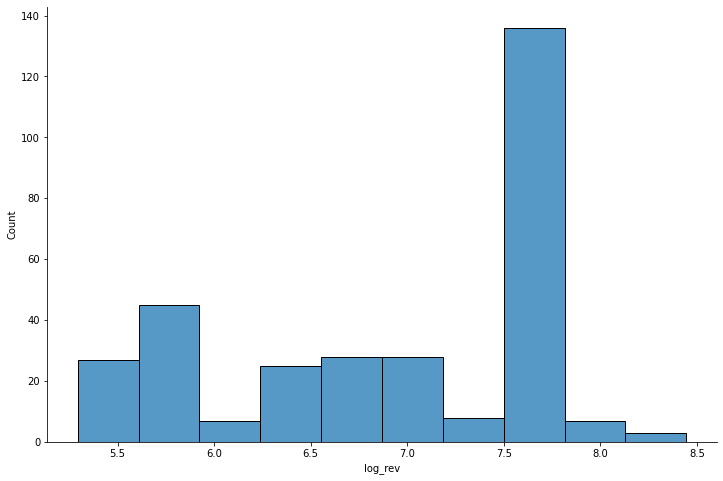

In [70]:
plt.figure(figsize=(12, 8))
sns.histplot(b_group.log_rev)
sns.despine()

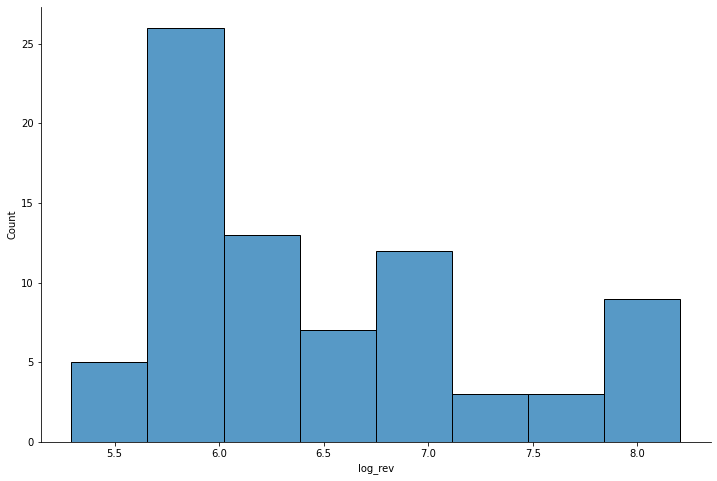

In [71]:
plt.figure(figsize=(12, 8))
sns.histplot(a_group.log_rev)
sns.despine()

In [72]:
print(shapiro(a_group.log_rev), shapiro(b_group.log_rev), sep="\n")

ShapiroResult(statistic=0.9057686924934387, pvalue=2.680935176613275e-05)
ShapiroResult(statistic=0.8419413566589355, pvalue=2.9242029102554055e-17)


Now we can consider that log_rev has normal distribution. 

**Testing hypothesis**

Lets check the following hypothesis.


> H0 - the distribution underlying a_group.log_rev is the same as the distribution underlying b_group.log_rev.



In [73]:
mannwhitneyu(a_group.rev, b_group.rev)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

Can reject H0, so there is a difference between groups.


> The next test using bootstrap is H0 - median in groups are the same == median difference is equal to 0.



In [77]:
print(a_group.rev.median(), b_group.rev.median(), sep="\n")

585.0
1140.0


In [78]:
a_group_rev = np.array(a_group.rev)
b_group_rev = np.array(b_group.rev)

In [79]:
print(bs.bootstrap_ab(a_group_rev, b_group_rev, bs_stats.median, bs_compare.percent_change))

-48.68421052631579    (-67.06539074960128, -25.5)


-48.6 is out of confidence interval, so we can reject H0. 

**Conclusion**

1. A and B groups' have different distributions so we choosed bootstrap to define is there a difference between medians of two groups;
2. Statistically significant difference on medians between A and B was shown.
